train.csv, test.csv
- game_id : Unique id for the game
- nickname : Player's username on woogles.io
- score : Final score for each player for each game.
- rating : Player's rating on woogles.io BEFORE the game was played; ratings are per Lexicon / time control name (AKA game variant). In test.csv, ratings are NA for player games; this is what you are predicting.

games.csv
- game_id : Unique id for the game
- first : Which player went first
- time_control_name : Name of time control used ("regular", "rapid", or "blitz")
- game_end_reason : How the game ended
- winner : Who won the game
- created_at : When the game was created
- lexicon : English lexicon used in the game ("CSW19", "NWL20", "CSW21")
- initial_time_seconds : Time limit each player has in the game (defines the time control name)
- increment_seconds : Time increment each player gets each time they play a turn
- rating_mode : Whether the game counts towards player ratings or not ("RATED", "CASUAL")
- max_overtime_minutes : How far past the initial time limit players can go before they timeout
- game_duration_seconds : How long the game lasted

turns.csv
- turns.csv contains full data for every turn for each game.
- game_id : Unique id for the game
- turn_number : The turn number in the game
- nickname : Player's username on woogles.io
- rack : Player's current rack
- location : Where the player places their turn on the board (NA for games in the test set or if the player didn't make a play, e.g., if they exchanged)
- move : Tiles the player laid (NA for games in the test set; "--" if the turn_type was "Pass"; "(challenge)" if the turn_type was "Challenge"; "-" plus tiles exchanged if the turn_type was "Exchange"; at the end of the game, remaining tiles in a player's rack are in parentheses)
- points : Points the player earned (or lost) in their turn
- score : Player's total score at the time of the turn
- turn_type : Type of turn played ("Play", "Exchange", "Pass", "Six-Zero Rule" (i.e., a game that ends when players pass 3 turns in a row each), "Challenge")

## 시작

In [151]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from xgboost import plot_importance
import numpy as np

In [152]:
train = pd.read_csv('train.csv')
print(len(train))
train.head(3)

100820


,game_id,nickname,score,rating
0,1,BetterBot,335,1637
1,1,stevy,429,1500
2,3,davidavid,440,1811


In [153]:
test = pd.read_csv('test.csv')
test.head(3)

,game_id,nickname,score,rating
0,2,Super,488,NaN
1,2,BetterBot,401,2000.0
2,7,STEEBot,377,2082.0


- games

In [154]:
games = pd.read_csv('games.csv')
games['created_at_yyyy'] = games.created_at.str[0:4]
games['created_at_mm'] = games.created_at.str[5:7]
games['created_at_hh'] = games.created_at.str[11:13]
games.head()

,game_id,first,time_control_name,game_end_reason,winner,created_at,lexicon,initial_time_seconds,increment_seconds,rating_mode,max_overtime_minutes,game_duration_seconds,created_at_yyyy,created_at_mm,created_at_hh
0,1,BetterBot,regular,STANDARD,1,2022-08-26 03:38:49,NWL20,1200,0,CASUAL,1,674.844274,2022,08,03
1,2,Super,regular,STANDARD,1,2022-08-10 19:19:59,CSW21,3600,0,RATED,1,364.214418,2022,08,19
2,3,BetterBot,regular,STANDARD,1,2022-09-04 08:04:27,CSW21,900,0,RATED,5,492.268262,2022,09,08
3,4,BetterBot,regular,RESIGNED,0,2022-09-12 02:36:19,CSW21,3600,0,CASUAL,1,350.861141,2022,09,02
4,5,STEEBot,regular,STANDARD,0,2022-09-06 04:31:36,NWL20,1200,0,CASUAL,1,642.688722,2022,09,04


In [155]:
games.rating_mode.unique()

array(['CASUAL', 'RATED'], dtype=object)

In [156]:
print(len(games['game_id'].unique()))
print(len(games))

72773
72773


- turns

In [157]:
turns = pd.read_csv('turns.csv')
turns['cnt']=1
turns.head()

,game_id,turn_number,nickname,rack,location,move,points,score,turn_type,cnt
0,1,1,BetterBot,DDEGITT,8G,DIG,10,10,Play,1
1,1,2,stevy,AEHOPUX,7H,HAP,18,18,Play,1
2,1,3,BetterBot,DEELTTU,6I,LUTE,16,26,Play,1
3,1,4,stevy,EMORSUX,5K,UM,16,34,Play,1
4,1,5,BetterBot,ACDEITU,L5,..DICATE,28,54,Play,1


- add variable : ncikname_gubun

In [158]:
train['nickname_gubun'] = 0
train['nickname2'] = train['nickname'].str.upper()
train.loc[train.nickname2.str.contains('BOT'),'nickname_gubun'] = 1

test['nickname_gubun'] = 0
test['nickname2'] = test['nickname'].str.upper()
test.loc[test.nickname2.str.contains('BOT'),'nickname_gubun'] = 1

turns['nickname_gubun'] = 0
turns['nickname2'] = turns['nickname'].str.upper()
turns.loc[turns.nickname2.str.contains('BOT'),'nickname_gubun'] = 1

- merge : train,test + games

In [159]:
print(len(train))
train = pd.merge(train, games, on ='game_id',how='left')
print(len(train))

print(len(test))
test = pd.merge(test, games, on ='game_id',how='left')
print(len(test))

100820
100820
44726
44726


- add variable : game_length

In [160]:
imsi = turns.groupby(['game_id'])['cnt'].sum().reset_index()
imsi.rename(columns={'cnt':'game_length'},inplace=True)
imsi.head(2)

,game_id,game_length
0,1,27
1,2,26


In [161]:
print(len(train))
train = pd.merge(train, imsi, on ='game_id',how='left')
print(len(train))

print(len(test))
test = pd.merge(test, imsi, on ='game_id',how='left')
print(len(test))

del imsi 

100820
100820
44726
44726


- add variable : points_per_games

In [162]:
# 한 차례에 보통 몇 점 정도를 얻는지(0:일반, 1:로봇)
imsi = turns.groupby(['game_id','nickname_gubun'])['points'].mean().reset_index()
imsi.rename(columns={'points':'points_per_games'},inplace=True)
imsi.head()

,game_id,nickname_gubun,points_per_games
0,1,0,30.642857
1,1,1,25.769231
2,2,0,34.857143
3,2,1,33.416667
4,3,0,31.428571


In [163]:
print(len(train))
train = pd.merge(train, imsi, on =['game_id','nickname_gubun'],how='left')
print(len(train))

print(len(test))
test = pd.merge(test, imsi, on =['game_id','nickname_gubun'],how='left')
print(len(test))

del imsi 

100820
100820
44726
44726


- add variable : turn_type

In [164]:
imsi = turns.groupby(['game_id','nickname_gubun','turn_type'])['cnt'].sum().reset_index()
imsi = imsi.pivot_table(index=['game_id','nickname_gubun'],columns=['turn_type']).reset_index()
imsi.columns = ['game_id','nickname_gubun','Challenge','End','Exchange','Pass','Play','Six-Zero Rule','Timeout']
imsi.fillna(0,inplace=True)
imsi.head()

,game_id,nickname_gubun,Challenge,End,Exchange,Pass,Play,Six-Zero Rule,Timeout
0,1,0,0.0,1.0,0.0,0.0,13.0,0.0,0.0
1,1,1,0.0,0.0,0.0,0.0,13.0,0.0,0.0
2,2,0,0.0,1.0,1.0,1.0,11.0,0.0,0.0
3,2,1,0.0,0.0,0.0,0.0,12.0,0.0,0.0
4,3,0,0.0,1.0,0.0,0.0,13.0,0.0,0.0


In [165]:
print(len(train))
train = pd.merge(train, imsi, on =['game_id','nickname_gubun'],how='left')
print(len(train))

print(len(test))
test = pd.merge(test, imsi, on =['game_id','nickname_gubun'],how='left')
print(len(test))

del imsi 

100820
100820
44726
44726


In [166]:
print(train.isna().sum().sum())
print(test.isna().sum().sum()) # rating na

0
22363


- type change

In [167]:
train=train.astype({'created_at_mm':int,'created_at_hh':int})
test=test.astype({'created_at_mm':int,'created_at_hh':int})

- add variable : first_gubun

In [168]:
train['first_gubun'] = 0
train['first2'] = train['first'].str.upper()
train.loc[train.first2.str.contains('BOT'),'first_gubun'] = 1

test['first_gubun'] = 0
test['first2'] = test['first'].str.upper()
test.loc[test.first2.str.contains('BOT'),'first_gubun'] = 1

- correlation

In [169]:
train.corr()

C:\Users\USER\AppData\Local\Temp\ipykernel_9768\2189804198.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  train.corr()


,game_id,score,rating,nickname_gubun,winner,initial_time_seconds,increment_seconds,max_overtime_minutes,game_duration_seconds,created_at_mm,created_at_hh,game_length,points_per_games,Challenge,End,Exchange,Pass,Play,Six-Zero Rule,Timeout,first_gubun
game_id,1.000000,0.000306,0.002249,-0.000141,0.006364,0.002364,-0.002151,-0.001493,0.004203,0.001662,-0.002143,0.002137,-0.000297,0.003866,0.001091,-0.003226,0.007117,-0.000483,0.004749,-0.000050,0.004018
score,0.000306,1.000000,0.425136,0.304909,0.026130,0.061631,-0.001568,-0.061679,0.001401,0.059055,0.004149,-0.198346,0.826788,0.049719,0.231327,-0.243872,-0.133046,-0.079410,-0.029680,-0.159108,-0.006295
rating,0.002249,0.425136,1.000000,0.367443,0.003908,0.149568,0.005766,-0.434311,0.150011,0.002996,-0.029598,-0.269352,0.464810,0.037079,0.086803,-0.155588,-0.044280,-0.227830,-0.030732,-0.069580,-0.003711
nickname_gubun,-0.000141,0.304909,0.367443,1.000000,-0.000207,-0.000100,-0.000031,-0.000150,0.000074,0.000305,-0.000059,0.000053,0.220136,0.039893,0.142893,-0.182519,-0.021175,0.059986,-0.000020,-0.141371,0.000340
winner,0.006364,0.026130,0.003908,-0.000207,1.000000,0.026618,0.014037,0.086464,-0.029692,-0.013390,-0.001769,-0.037707,0.036277,-0.024203,0.036121,-0.064589,-0.016427,-0.013425,0.009963,-0.075796,-0.094863
initial_time_seconds,0.002364,0.061631,0.149568,-0.000100,0.026618,1.000000,0.183511,-0.045173,0.345675,0.050047,-0.035202,-0.090981,0.096822,-0.006973,0.004685,-0.013942,0.012761,-0.094582,-0.004312,-0.068812,0.000977
increment_seconds,-0.002151,-0.001568,0.005766,-0.000031,0.014037,0.183511,1.000000,-0.068178,0.100689,-0.024589,-0.021198,-0.032065,0.015247,0.010593,-0.003871,-0.007365,0.013631,-0.035434,-0.003629,-0.012994,0.002121
max_overtime_minutes,-0.001493,-0.061679,-0.434311,-0.000150,0.086464,-0.045173,-0.068178,1.000000,-0.234576,0.134197,-0.009929,0.061558,-0.092494,-0.016807,0.017584,-0.015565,-0.000926,0.072575,0.031761,-0.045540,0.004939
game_duration_seconds,0.004203,0.001401,0.150011,0.000074,-0.029692,0.345675,0.100689,-0.234576,1.000000,-0.023742,0.010622,-0.014414,0.011063,0.002738,-0.037920,0.025072,0.004069,-0.032316,0.004462,0.188249,-0.004601
created_at_mm,0.001662,0.059055,0.002996,0.000305,-0.013390,0.050047,-0.024589,0.134197,-0.023742,1.000000,0.002611,-0.080458,0.088712,-0.000442,0.000656,0.001150,0.004112,-0.087749,-0.006638,-0.001468,0.000215


In [170]:
pd.set_option('display.max_columns', None)
train.head()

,game_id,nickname,score,rating,nickname_gubun,nickname2,first,time_control_name,game_end_reason,winner,created_at,lexicon,initial_time_seconds,increment_seconds,rating_mode,max_overtime_minutes,game_duration_seconds,created_at_yyyy,created_at_mm,created_at_hh,game_length,points_per_games,Challenge,End,Exchange,Pass,Play,Six-Zero Rule,Timeout,first_gubun,first2
0,1,BetterBot,335,1637,1,BETTERBOT,BetterBot,regular,STANDARD,1,2022-08-26 03:38:49,NWL20,1200,0,CASUAL,1,674.844274,2022,8,3,27,25.769231,0.0,0.0,0.0,0.0,13.0,0.0,0.0,1,BETTERBOT
1,1,stevy,429,1500,0,STEVY,BetterBot,regular,STANDARD,1,2022-08-26 03:38:49,NWL20,1200,0,CASUAL,1,674.844274,2022,8,3,27,30.642857,0.0,1.0,0.0,0.0,13.0,0.0,0.0,1,BETTERBOT
2,3,davidavid,440,1811,0,DAVIDAVID,BetterBot,regular,STANDARD,1,2022-09-04 08:04:27,CSW21,900,0,RATED,5,492.268262,2022,9,8,27,31.428571,0.0,1.0,0.0,0.0,13.0,0.0,0.0,1,BETTERBOT
3,3,BetterBot,318,2071,1,BETTERBOT,BetterBot,regular,STANDARD,1,2022-09-04 08:04:27,CSW21,900,0,RATED,5,492.268262,2022,9,8,27,24.461538,0.0,0.0,1.0,0.0,12.0,0.0,0.0,1,BETTERBOT
4,4,Inandoutworker,119,1473,0,INANDOUTWORKER,BetterBot,regular,RESIGNED,0,2022-09-12 02:36:19,CSW21,3600,0,CASUAL,1,350.861141,2022,9,2,29,8.500000,0.0,0.0,2.0,0.0,12.0,0.0,0.0,1,BETTERBOT


In [171]:
train.columns

Index(['game_id', 'nickname', 'score', 'rating', 'nickname_gubun', 'nickname2',
       'first', 'time_control_name', 'game_end_reason', 'winner', 'created_at',
       'lexicon', 'initial_time_seconds', 'increment_seconds', 'rating_mode',
       'max_overtime_minutes', 'game_duration_seconds', 'created_at_yyyy',
       'created_at_mm', 'created_at_hh', 'game_length', 'points_per_games',
       'Challenge', 'End', 'Exchange', 'Pass', 'Play', 'Six-Zero Rule',
       'Timeout', 'first_gubun', 'first2'],
      dtype='object')

## model

- test1 : 0.9557134800161213
- test2 : 0.9554823871904214

R2: 0.9554823871904214


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

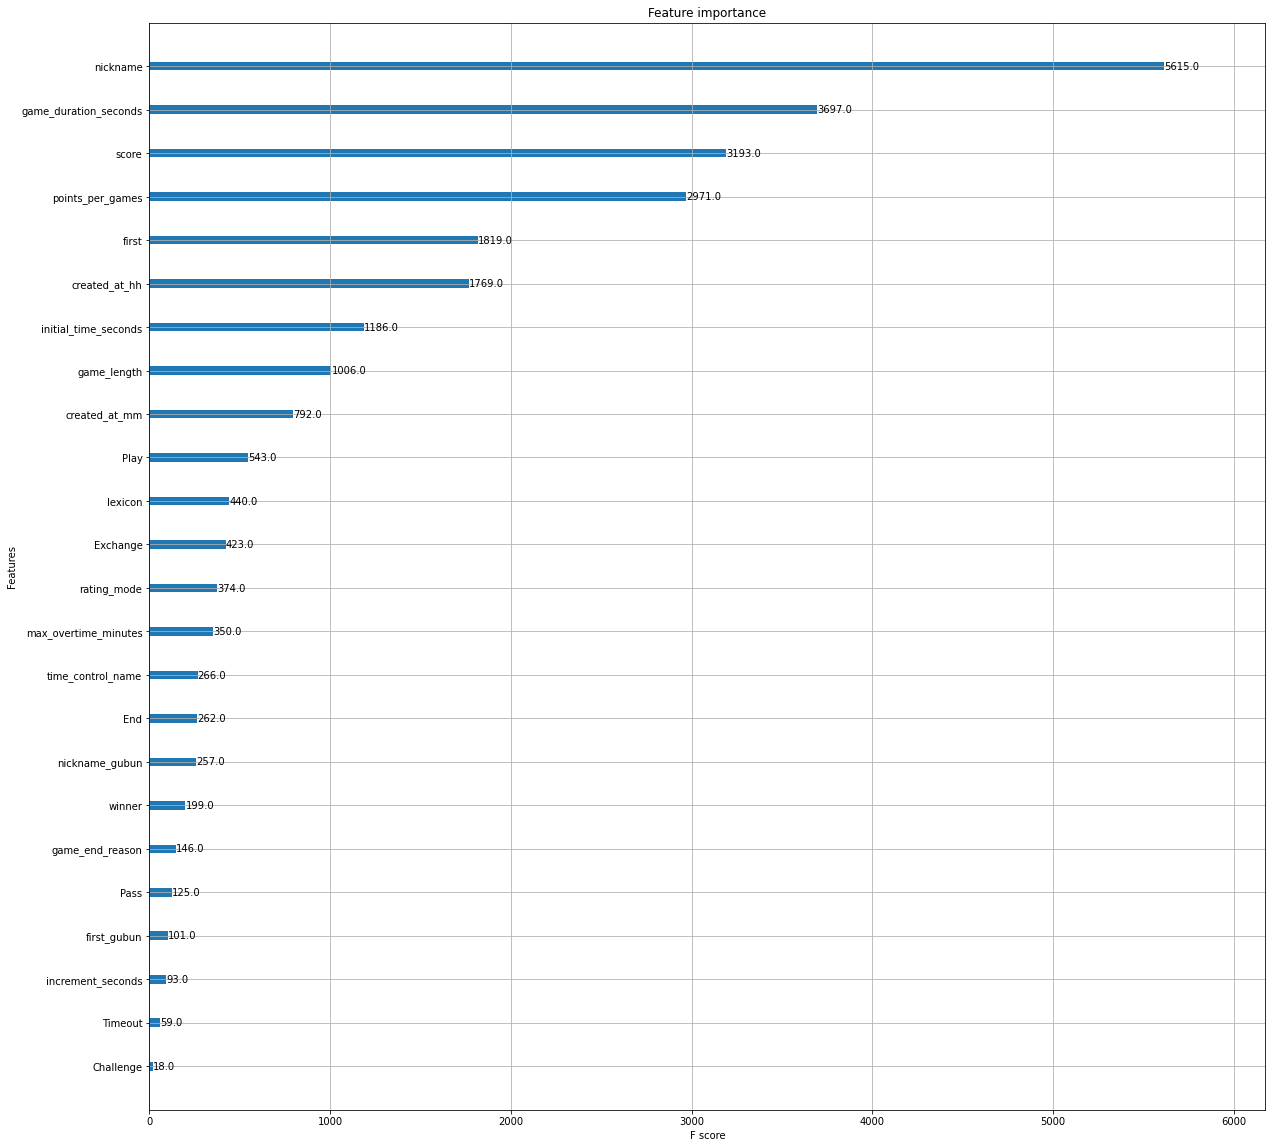

In [172]:
# 변수 선택
col_nm = ['nickname','score','nickname_gubun','first','time_control_name','game_end_reason','winner','lexicon','initial_time_seconds',
          'increment_seconds','rating_mode','max_overtime_minutes','game_duration_seconds','created_at_mm','created_at_hh',
          'game_length','points_per_games','Challenge', 'End', 'Exchange', 'Pass', 'Play', 'Six-Zero Rule',
          'Timeout', 'first_gubun']


# label encoding
str_col = ['nickname','first','time_control_name','game_end_reason','lexicon','rating_mode']
for i in str_col:
    le = LabelEncoder()
    le=le.fit(train[i])
    train[i]=le.transform(train[i])
    
#     for label in np.unique(test[i]):
    for label in (test[i].unique()):
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test[i]=le.transform(test[i])

x_train, x_valid, y_train, y_valid = train_test_split(train[col_nm], train['rating'], test_size=0.2, shuffle=True, random_state=34)
# print(x_train.shape,y_train.shape)

model = XGBRegressor(n_estimators=500)
model.fit(x_train,y_train) 

from sklearn.metrics import accuracy_score

y_pred = model.predict(x_valid) # 예측 라벨(0과 1로 예측)

# 예측 라벨과 실제 라벨 사이의 정확도 측정
# print('정확도:', accuracy_score(y_pred, y_valid)) 
print('R2:', model.score(x_valid, y_valid)) 

preds = model.predict(test[col_nm])

test['preds'] = preds
final_preds = test[test.rating.isna()][['game_id','preds']]
final_preds.rename(columns={'preds':'rating'},inplace=True)
final_preds.to_csv('submission.csv',index=False)
plt.rcParams["figure.figsize"] = (20,20)
plot_importance(model)
